In [3]:
import torch 
import torch.autograd as autograd 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import spacy
import re
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from collections import defaultdict
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## Functions for Cleaning Text

In [4]:
re_br = re.compile(r'<\s*br\s*/?>', re.IGNORECASE)
def sub_br(x): return re_br.sub("\n", x)

my_tok = spacy.load('en')
def spacy_tok(x): return [tok.text for tok in my_tok.tokenizer(sub_br(x))]

## Functions for Sentiment Analysis

In [5]:
def sentiment(arr):
    scores = []
    analyser = SentimentIntensityAnalyzer()
    for row in arr:
        text = re.sub(r'^https?:\/\/.*[\r\n]*', '', row, flags=re.MULTILINE)
        text = re.sub(r'^http?:\/\/.*[\r\n]*', '', row, flags=re.MULTILINE)
        scores.append(list(analyser.polarity_scores(text).values()))
    return np.array(scores)

## Functions for Encoding Sentences

In [6]:
def get_vocab(content):
    """Computes Dict of counts of words.
    
    Computes the number of times a word is on a document.
    """
    vocab = defaultdict(float)
    for line in content:
        for word in line.split():
            vocab[word] += 1
    return vocab

def encode_sentence(x, vocab2index, N=26, padding_start=True):
    enc = np.zeros(N, dtype=np.int32)
    enc1 = [vocab2index.get(w, vocab2index["UNK"]) for w in x.split()]
    l = min(N, len(enc1))
    if padding_start:
        enc[N-l:] = enc1[:l]
    else:
        enc = enc1[:l]
    return enc

In [70]:
class TweetDataset(Dataset):
    def __init__(self, X, y, vocab2index, N = 26,padding_start = True):
        self.X = np.array([encode_sentence(x,vocab2index, N, padding_start) for x in X])
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        x = self.X[idx]
        return x, self.y[idx]

## Gather Pre-Training Embeddings

In [8]:
def unpack_glove():
    ! wget http://nlp.stanford.edu/data/glove.6B.zip
    ! mkdir data
    ! unzip glove.6B.zip
    
def delete_rare_words(word_vecs, word_count, min_df=4):
    words_delete = []
    for word in word_count:
        if word_count[word] < min_df and word not in word_vecs:
            words_delete.append(word)
    for word in words_delete: word_count.pop(word)
    return word_count

def loadGloveModel(gloveFile="glove.6B.50d.txt"):
    """ Loads word vecgors into a dictionary"""
    f = open(gloveFile,'r')
    word_vecs = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        word_vecs[word] = np.array([float(val) for val in splitLine[1:]])
    return word_vecs

def create_embedding_matrix(word_vecs, word_count, min_df=4, emb_size=50):
    """Creates embedding matrix from word vectors. """
    word_count = delete_rare_words(word_vecs, word_count, min_df)
    V = len(word_count.keys()) + 2
    vocab2index = {}
    W = np.zeros((V, emb_size), dtype="float32")
    vocab = ["", "UNK"]
    # adding a vector for padding
    W[0] = np.zeros(emb_size, dtype='float32')
    # adding a vector for rare words 
    W[1] = np.random.uniform(-0.25, 0.25, emb_size)
    vocab2index["UNK"] = 1
    i = 2
    for word in word_count:
        if word in word_vecs:
            W[i] = word_vecs[word]
            vocab2index[word] = i
            vocab.append(word)
            i += 1
        else:
            W[i] = np.random.uniform(-0.25,0.25, emb_size)
            vocab2index[word] = i
            vocab.append(word)
            i += 1   
    return W, np.array(vocab), vocab2index

## CNN Model 

In [89]:
class Tweet_CNN(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_dim = 25,glove_weights=None):
        super(Tweet_CNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, emb_size, padding_idx = 0)
        
        if glove_weights is not None:
            self.embed.weight.data.copy_(torch.from_numpy(glove_weights))
            self.embed.weight.requires_grad = False
            
        # For the Text Data
        self.conv1 = nn.Conv1d(emb_size, hidden_dim, kernel_size=1)
        self.conv2 = nn.Conv1d(emb_size, hidden_dim, kernel_size=2)
        self.conv3 = nn.Conv1d(emb_size, hidden_dim, kernel_size=3)
        
        self.pool1 = nn.AvgPool1d(kernel_size = 26)
        self.pool2 = nn.AvgPool1d(kernel_size = 25)
        self.pool3 = nn.AvgPool1d(kernel_size = 24)
        
        # For Both
        self.bn = nn.BatchNorm1d(hidden_dim*3)
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(hidden_dim*3, 1)

    def forward(self, x):
        x = self.embed(x)
        x = x.transpose(1,2)
        x1 = self.pool1(F.relu(self.conv1(x)))
        x2 = self.pool2(F.relu(self.conv2(x)))
        x3 = self.pool3(F.relu(self.conv3(x)))
        
        out = torch.cat([x1, x2, x3], 2)
        #out = torch.cat([x2, x3], 2)
        out = out.view(out.size(0), -1)
        out = self.dropout(self.bn(out))
        
        return self.fc(out)

## Training Functions

In [10]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [39]:
def train_epocs(model, optimizer, epochs=10, max_lr=0.01):
    max_f1 = 0
    max_acc = 0
    min_loss = 1000000
    for i in range(epochs):
        model.train()
        total_loss = 0
        total = 0
        iterations = epochs*len(train_dl)
        idx = 0
        lrs = get_cosine_triangular_lr(max_lr, iterations)
        for x, y in train_dl:
            lr = lrs[idx]
            update_optimizer(optimizer,lr)
            x = x.long()
            y = y.float().unsqueeze(1)
            out = model(x)
            loss = F.binary_cross_entropy_with_logits(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += x.size(0)*loss.item()
            total += x.size(0)
            idx +=1
        train_loss = total_loss/total
        val_loss, val_accuracy, val_f1 = valid_metrics(model)
        
        if val_f1 > max_f1:
            max_f1 = val_f1
            max_acc = val_accuracy
            min_loss = val_loss
            path = "models/model_f1_{0:.3f}.pth".format(val_f1) 
            save_model(model, path)      
        #if i % 20 == 0:
        print("train_loss %.3f val_loss %.3f val_accuracy %.3f val_f1 %.3f" % (
                train_loss, val_loss, val_accuracy, val_f1))
    #print("Best Scores: val_loss %.3f val_accuracy %.3f val_f1 %.3f" % (
    #             min_loss, max_acc, max_f1))

In [40]:
def valid_metrics(model):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    y_all = []
    y_pred_all = []
    for x, y in valid_dl:
        x = x.long()
        y = y.float().unsqueeze(1)
        batch = y.shape[0]
        out = model(x)
        loss = F.binary_cross_entropy_with_logits(out, y)
        sum_loss += batch*(loss.item())
        total += batch
        pred = (out > 0).float()
        y_pred_all.extend(pred)
        y_all.extend(y)
        correct += (pred == y).float().sum().item()
    val_loss = sum_loss/total
    val_acc = correct/total
    val_f1 = f1_score(y_pred_all, y_all)
    return val_loss, val_acc, val_f1

## Learning Rate Finding

In [41]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

def update_optimizer(optimizer, lr):
    for _,param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [42]:
def LR_range_finder(model, optimizer, train_dl, lr_low=1e-5, lr_high=1e-2, epochs=2):
    losses = []
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    for i in range(epochs):
        for x, y in train_dl:
            lr = lrs[ind]
            update_optimizer(optimizer,lr)
            x = x.long() #.cuda()
            y = y.float().unsqueeze(1) #.cuda()
            out = model(x)
            loss = F.binary_cross_entropy_with_logits(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            ind +=1
    return lrs, losses 

## Model Troubleshooting

In [43]:
x, y = next(iter(train_dl))

In [808]:
V = len(words)
emb_size = 3

In [809]:
embed = nn.Embedding(V, emb_size, padding_idx=0)

In [810]:
# Kernal = 1

In [813]:
x1 = embed(x.long())

In [816]:
x1.transpose(1,2).shape

torch.Size([2, 3, 26])

In [779]:
x1 = embed(x.long())
x1 = x1.transpose(1,2)
x1.size()
conv_1 = nn.Conv1d(in_channels=emb_size, out_channels=100, kernel_size=1)
x1 = F.relu(conv_1(x1))
pool1 = nn.MaxPool1d(kernel_size = 26)
x1 = pool1(x1)

In [787]:
conv_1(embed(x.long()).transpose(1,2)).shape

torch.Size([2, 100, 26])

In [781]:
x1.shape

torch.Size([2, 100, 1])

In [763]:
## Kernal = 2

In [764]:
x2 = embed(x.long())
x2 = x2.transpose(1,2)
x2.size()
conv_2 = nn.Conv1d(in_channels=emb_size, out_channels=100, kernel_size=2)
x2 = F.relu(conv_2(x2))
pool2 = nn.MaxPool1d(kernel_size = 25)
x2 = pool2(x2)

In [765]:
## Kernal = 3

In [766]:
x3 = embed(x.long())
x3 = x3.transpose(1,2)
x3.size()
conv_3 = nn.Conv1d(in_channels=emb_size, out_channels=100, kernel_size=3)
x3 = F.relu(conv_3(x3))
pool3 = nn.MaxPool1d(kernel_size = 24)
x3 = pool3(x3)

In [751]:
out = torch.cat([x1, x2, x3], 2)

In [788]:
out.shape

torch.Size([2, 100, 3])

In [789]:
out = out.view(out.size(0), -1)

In [790]:
dropout = nn.Dropout(p=0.2)
out = dropout(bn(out))

In [792]:
out.shape

torch.Size([2, 300])

In [290]:
bn = nn.BatchNorm1d(300)

## Running everything

In [379]:
#unpack_glove()

--2020-06-21 18:57:49--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-06-21 18:57:49--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-06-21 18:57:49--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [94]:
disaster = pd.read_csv('nlp-getting-started/train.csv')

In [95]:
X = np.array(disaster.text)
y = np.array(disaster.target)

In [107]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=40)

In [62]:
word_count = get_vocab(X_train)
for word in list(word_count):
    if word_count[word] < 5:
        del word_count[word]

In [25]:
vocab2index = {"<PAD>":0, "UNK":1} # init with padding and unknown
words = ["<PAD>", "UNK"]
for word in word_count:
    vocab2index[word] = len(words)
    words.append(word)

In [63]:
word_vecs = loadGloveModel(gloveFile="glove.6B.50d.txt")
word_count = delete_rare_words(word_vecs, word_count)
pretrained_weight, vocab, vocab2index = create_embedding_matrix(word_vecs, word_count, emb_size=50)

In [60]:
pretrained_weight, vocab, vocab2index = create_embedding_matrix(word_vecs, word_count, emb_size=50)

In [69]:
vocab

array(['', 'UNK', 'Heavy', ..., 'pay', 'peanut', '.:'], dtype='<U22')

In [ ]:
V = len(words)
emb_size = 50

In [108]:
train_ds = TweetDataset(X_train, y_train, vocab2index)
valid_ds = TweetDataset(X_val, y_val, vocab2index)
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=128)

In [73]:
train_ds[0]

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  2,  3,  4,
         5,  6,  7,  8,  9,  1, 10,  1, 11], dtype=int32),
 1)

In [103]:
model = Tweet_CNN(V, emb_size)

In [75]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
lrs,losses = LR_range_finder(model, optimizer, train_dl)

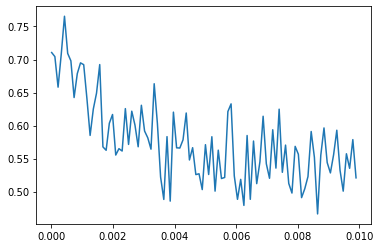

In [76]:
plt.plot(lrs, losses)
plt.show()

In [130]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train_epocs(model, optimizer, epochs = 200, max_lr=1e-4)

train_loss 0.296 val_loss 0.510 val_accuracy 0.799 val_f1 0.754
train_loss 0.293 val_loss 0.509 val_accuracy 0.802 val_f1 0.760
train_loss 0.298 val_loss 0.510 val_accuracy 0.800 val_f1 0.756
train_loss 0.296 val_loss 0.509 val_accuracy 0.794 val_f1 0.747
train_loss 0.285 val_loss 0.509 val_accuracy 0.802 val_f1 0.762
train_loss 0.297 val_loss 0.510 val_accuracy 0.800 val_f1 0.759
train_loss 0.291 val_loss 0.507 val_accuracy 0.797 val_f1 0.751
train_loss 0.295 val_loss 0.508 val_accuracy 0.796 val_f1 0.750
train_loss 0.290 val_loss 0.510 val_accuracy 0.800 val_f1 0.759
train_loss 0.292 val_loss 0.509 val_accuracy 0.799 val_f1 0.758
train_loss 0.290 val_loss 0.509 val_accuracy 0.796 val_f1 0.746
train_loss 0.298 val_loss 0.509 val_accuracy 0.798 val_f1 0.754
train_loss 0.292 val_loss 0.509 val_accuracy 0.800 val_f1 0.760
train_loss 0.288 val_loss 0.509 val_accuracy 0.797 val_f1 0.751
train_loss 0.296 val_loss 0.508 val_accuracy 0.800 val_f1 0.761
train_loss 0.292 val_loss 0.509 val_accu

train_loss 0.289 val_loss 0.511 val_accuracy 0.799 val_f1 0.756
train_loss 0.291 val_loss 0.509 val_accuracy 0.799 val_f1 0.756
train_loss 0.288 val_loss 0.511 val_accuracy 0.797 val_f1 0.751
train_loss 0.293 val_loss 0.512 val_accuracy 0.797 val_f1 0.751
train_loss 0.287 val_loss 0.512 val_accuracy 0.799 val_f1 0.756
train_loss 0.288 val_loss 0.510 val_accuracy 0.800 val_f1 0.757
train_loss 0.290 val_loss 0.515 val_accuracy 0.797 val_f1 0.752
train_loss 0.296 val_loss 0.511 val_accuracy 0.799 val_f1 0.757
train_loss 0.285 val_loss 0.512 val_accuracy 0.796 val_f1 0.752
train_loss 0.284 val_loss 0.513 val_accuracy 0.801 val_f1 0.760
train_loss 0.290 val_loss 0.512 val_accuracy 0.798 val_f1 0.755
train_loss 0.281 val_loss 0.512 val_accuracy 0.799 val_f1 0.756
train_loss 0.288 val_loss 0.513 val_accuracy 0.798 val_f1 0.756
train_loss 0.288 val_loss 0.510 val_accuracy 0.799 val_f1 0.756
train_loss 0.287 val_loss 0.510 val_accuracy 0.798 val_f1 0.754
train_loss 0.291 val_loss 0.514 val_accu

## This is the best Model we have for CNN

In [123]:
load_model(model, "/Users/skwong/Documents/Summer_Module/Deep_Learning/Project/models/model_f1_0.762.pth")

In [124]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=40)

In [125]:
train_ds = TweetDataset(X_train, y_train, vocab2index)
valid_ds = TweetDataset(X_val, y_val, vocab2index)
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=128)

In [126]:
valid_metrics(model)

(0.5083029800469517, 0.8030203545633617, 0.7615262321144672)

## Do model on Test Data

In [127]:
disaster_test = pd.read_csv('nlp-getting-started/test.csv')

In [129]:
X_test = np.array(disaster_test.text)
test_dl = DataLoader(train_ds, batch_size=128, shuffle=True)

In [ ]:
def valid_metrics(model):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    y_all = []
    y_pred_all = []
    for x, y in test_dl:
        x = x.long()
        out = model(x)
        loss = F.binary_cross_entropy_with_logits(out, y)
        sum_loss += batch*(loss.item())
        total += batch
        pred = (out > 0).float()
        y_pred_all.extend(pred)
        y_all.extend(y)
        correct += (pred == y).float().sum().item()
    val_loss = sum_loss/total
    val_acc = correct/total
    val_f1 = f1_score(y_pred_all, y_all)
    return val_loss, val_acc, val_f1